In [1]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
from __future__ import print_function
import pathlib
import IPython.display as ipd  # To play sound in the notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchsummary import summary
import random
from torchviz import make_dot, make_dot_from_trace

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.is_available()

True

In [5]:
# PATHS 

raw_data = '/home/ubuntu/speech2speech/data/raw/VCTK-Corpus'
interim_data = os.path.join('/home/ubuntu/speech2speech/data', 'interim')
spectogram_array_path =  os.path.join(interim_data, 'spectogram_array')
spectogram_array_path_trim_30db =  os.path.join(interim_data, 'spectogram_array_trim_30db')
spectrogram_path =os.path.join(interim_data, 'spectogram') 
audio_path = '/home/ubuntu/speech2speech/data/raw/VCTK-Corpus/wav48/'
trim_audio_path = '/home/ubuntu/speech2speech/data/trim_silence_30db'

In [6]:
# MKDIR
if not os.path.exists(interim_data):
    os.makedirs(interim_data)

if not os.path.exists(spectogram_array_path):
    os.mkdir(spectogram_array_path)

In [7]:
spectogram_array_path_trim_30db

'/home/ubuntu/speech2speech/data/interim/spectogram_array_trim_30db'

## Load Data 

In [8]:
import os
import glob

files_np = list(glob.glob(os.path.join(spectogram_array_path_trim_30db,'trim_spec_p249*')))

In [9]:
len(files_np)

335

In [10]:
col_shape = []
for file in files_np: 
    trial_x = np.load(file)
    _, cols = trial_x.shape
    col_shape.append(cols)

In [11]:
max_col = max(col_shape)
max_col

333

In [13]:
np.percentile(col_shape, 99)

212.88000000000045

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


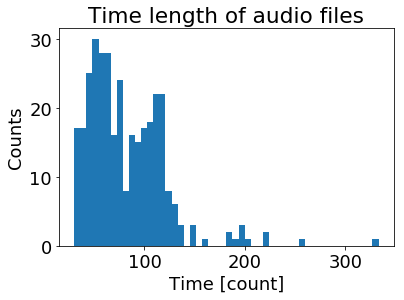

In [12]:
plt.rc("font", size=18, family="Helvetica")
params = {'legend.fontsize': 10 }
plt.rcParams.update(params)
plt.hist(col_shape, bins = 50)
plt.title("Time length of audio files")
plt.xlabel("Time [count]")
plt.ylabel("Counts")

max_col = max(col_shape)

In [12]:
max_col=100
X_list = []
Y_list = []
for file in files_np:     
    load_x = np.load(file)
    x = np.zeros((load_x.shape[0], max_col), dtype = np.float32)
    c = min(max_col, load_x.shape[1])
    x[:load_x.shape[0], :c] = load_x[:, :c]
    
    x =torch.tensor(x, device='cpu').float()
    trial_y = file.split('trim_spec_p')[1][:3]
    trial_y =torch.tensor(int(trial_y), device='cpu').float()
    X_list.append(x)
    Y_list.append(trial_y)

In [13]:
Y_np_list = []
for file in files_np: 
    trial_y = file.split('trim_spec_p')[1][:3]
    Y_np_list.append(trial_y)


In [14]:
Y_np_list= list(set(Y_np_list))

In [15]:
speaker_dic ={'264': 0,
 '298': 1,
 '269': 2,
 '329': 3,
 '314': 4,
 '340': 5,
 '255': 6,
 '299': 7,
 '250': 8,
 '243': 9,
 '234': 10,
 '351': 11,
 '300': 12,
 '361': 13,
 '281': 14,
 '287': 15,
 '259': 16,
 '310': 17,
 '297': 18,
 '248': 19,
 '256': 20,
 '244': 21,
 '288': 22,
 '263': 23,
 '245': 24,
 '236': 25,
 '227': 26,
 '225': 27,
 '280': 28,
 '295': 29,
 '293': 30,
 '228': 31,
 '240': 32,
 '270': 33,
 '233': 34,
 '363': 35,
 '311': 36,
 '262': 37,
 '276': 38,
 '231': 39,
 '230': 40,
 '305': 41,
 '257': 42,
 '374': 43,
 '339': 44,
 '251': 45,
 '252': 46,
 '268': 47,
 '335': 48,
 '317': 49,
 '241': 50,
 '267': 51,
 '265': 52,
 '237': 53,
 '343': 54,
 '294': 55,
 '312': 56,
 '304': 57,
 '232': 58,
 '258': 59,
 '247': 60,
 '334': 61,
 '278': 62,
 '364': 63,
 '261': 64,
 '226': 65,
 '360': 66,
 '282': 67,
 '330': 68,
 '239': 69,
 '246': 70,
 '238': 71,
 '316': 72,
 '283': 73,
 '273': 74,
 '347': 75,
 '318': 76,
 '274': 77,
 '285': 78,
 '333': 79,
 '313': 80,
 '303': 81,
 '272': 82,
 '292': 83,
 '253': 84,
 '266': 85,
 '275': 86,
 '308': 87,
 '307': 88,
 '326': 89,
 '323': 90,
 '315': 91,
 '286': 92,
 '249': 93,
 '277': 94,
 '301': 95,
 '376': 96,
 '306': 97,
 '345': 98,
 '362': 99,
 '254': 100,
 '279': 101,
 '302': 102,
 '341': 103,
 '271': 104,
 '260': 105,
 '229': 106,
 '336': 107,
 '284': 108}

In [16]:
x_Tensor= torch.stack(X_list)

In [17]:
y_Tensor= torch.stack(Y_list)

In [18]:
full_tensordataset = torch.utils.data.TensorDataset(x_Tensor, y_Tensor)

In [19]:
full_loader = torch.utils.data.DataLoader(full_tensordataset, batch_size= 10 ,pin_memory= True, shuffle= True  )

In [20]:
train_val_size = int(0.9 * len(full_tensordataset))
test_size = len(full_tensordataset)- train_val_size
train__val_dataset, test_dataset = torch.utils.data.random_split(full_tensordataset, [train_val_size, test_size])
train_size = int(0.9 * len(train__val_dataset))
val_size = len(train__val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train__val_dataset, [train_size, val_size])

In [21]:
len(train__val_dataset)

301

In [22]:
len(test_dataset)+len(train_dataset)+len(val_dataset)

335

In [23]:
x_Tensor.shape

torch.Size([335, 1025, 100])

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [24]:
batch_size = 10
num_training_updates = 15000

# Encoder
num_hiddens = 768
num_residual_hiddens = 256
num_residual_layers = 2
# input_dim: 256

# VQ
# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 300

# Commitment cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
# 0.25 as specified in the paper.
commitment_cost = 0.25

# Only uses for the EMA updates (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the original VQ-VAE paper [van den Oord et al., 2017],
# EMA updates were not used (but suggested in appendix) and compared in
# [Roy et al., 2018].
decay = -0.99

learning_rate = 1e-4

embedding2_dim = 20
speaker_id = '249'
num_epochs   = 20

In [25]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, device):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._device = device

    def forward(self, inputs):
        #print('shape of inputs in VectorQuantizer.forward',inputs.size())
        # convert inputs from BCHW (here its B, F, T) -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        #print('shape of permutated inputs in VectorQuantizer.forward',input_shape)
        
        
        _, time, batch_size = input_shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        #print('shape of flat_input in VectorQuantizer.forward',flat_input.size())
        #print('device of flat_input',flat_input.device)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        #print('shape of quantized in VectorQuantizer.forward',quantized.size())
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        #print('shape of inputs quantized in VectorQuantizer.forward',quantized.size())
        #print("with inputs quantized: "quantized.size())
        
        # convert quantized from BHWC -> BCHW 
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [26]:
class VectorQuantizerEMA(nn.Module):
    """
    Inspired from Sonnet implementation of VQ-VAE https://arxiv.org/abs/1711.00937,
    in https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py and
    pytorch implementation of it from zalandoresearch in https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb.
    Implements a slightly modified version of the algorithm presented in
    'Neural Discrete Representation Learning' by van den Oord et al.
    https://arxiv.org/abs/1711.00937
    The difference between VectorQuantizerEMA and VectorQuantizer is that
    this module uses exponential moving averages to update the embedding vectors
    instead of an auxiliary loss. This has the advantage that the embedding
    updates are independent of the choice of optimizer (SGD, RMSProp, Adam, K-Fac,
    ...) used for the encoder, decoder and other parts of the architecture. For
    most experiments the EMA version trains faster than the non-EMA version.
    Input any tensor to be quantized. Last dimension will be used as space in
    which to quantize. All other dimensions will be flattened and will be seen
    as different examples to quantize.
    The output tensor will have the same shape as the input.
    For example a tensor with shape [16, 32, 32, 64] will be reshaped into
    [16384, 64] and all 16384 vectors (each of 64 dimensions)  will be quantized
    independently.
    Args:
        embedding_dim: integer representing the dimensionality of the tensors in the
            quantized space. Inputs to the modules must be in this format as well.
        num_embeddings: integer, the number of vectors in the quantized space.
            commitment_cost: scalar which controls the weighting of the loss terms (see
            equation 4 in the paper).
        decay: float, decay for the moving averages.
        epsilon: small float constant to avoid numerical instability.
    """
        
        
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, device, epsilon=1e-5):
           
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon
        self._device = device

    def forward(self, inputs, compute_distances_if_possible=True, record_codebook_stats=False):
        """
        Connects the module to some inputs.
        Args:
            inputs: Tensor, final dimension must be equal to embedding_dim. All other
                leading dimensions will be flattened and treated as a large batch.
        
        Returns:
            loss: Tensor containing the loss to optimize.
            quantize: Tensor containing the quantized version of the input.
            perplexity: Tensor containing the perplexity of the encodings.
            encodings: Tensor containing the discrete encodings, ie which element
                of the quantized space each input element was mapped to.
            distances
        """

        
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(1, 2, 0).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        """
        encoding_indices: Tensor containing the discrete encoding indices, ie
        which element of the quantized space each input element was mapped to.
        """
        
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, dtype=torch.float).to(self._device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Compute distances between encoding vectors
        if not self.training and compute_distances_if_possible:
            _encoding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in combinations(flat_input, r=2)]
            encoding_distances = torch.tensor(_encoding_distances).to(self._device).view(batch_size, -1)
        else:
            encoding_distances = None

        # Compute distances between embedding vectors
        if not self.training and compute_distances_if_possible:
            _embedding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in combinations(self._embedding.weight, r=2)]
            embedding_distances = torch.tensor(_embedding_distances).to(self._device)
        else:
            embedding_distances = None

        # Sample nearest embedding
        if not self.training and compute_distances_if_possible:
            _frames_vs_embedding_distances = [torch.dist(items[0], items[1], 2).to(self._device) for items in product(flat_input, self._embedding.weight.detach())]
            frames_vs_embedding_distances = torch.tensor(_frames_vs_embedding_distances).to(self._device).view(batch_size, time, -1)
        else:
            frames_vs_embedding_distances = None
        
        
        

        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        concatenated_quantized = self._embedding.weight[torch.argmin(distances, dim=1).detach().cpu()] if not self.training or record_codebook_stats else None
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        """
        The perplexity a useful value to track during training.
        It indicates how many codes are 'active' on average.
        """
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(2, 0, 1).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [27]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        
        """
        2 preprocessing convolution layers with filter length 3
        and residual connections.
        """
        

        self._conv_1 = nn.Conv1d(in_channels= 1025, #??features_filters,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._conv_2 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        """
        1 strided convolution length reduction layer with filter
        length 4 and stride 2 (downsampling the signal by a factor
        of two).
        """
        
        self._conv_3 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=1, 
                                 padding=2)
        """
        2 convolutional layers with length 3 and
        residual connections.
        """
        self._conv_4 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._conv_5 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        #print('shape of inputs in Encoder.forward',inputs.size())

        x_conv_1 = F.relu(self._conv_1(inputs))
        #print('shape of x in Encoder.forward._conv_1',x_conv_1.size())

        x = F.relu(self._conv_2(x_conv_1)) + x_conv_1
        #print('shape of x in Encoder.forward.relu_2',x.size())
        
        x_conv_3 = F.relu(self._conv_3(x))
        #print('shape of x_conv_3 in Encoder.forward._conv_3',x_conv_3.size())
        
        x_conv_4 = F.relu(self._conv_4(x_conv_3)) + x_conv_3
        #print('shape of x_conv_4 in Encoder.forward._conv_4',x_conv_4.size())
        
        x_conv_5 = F.relu(self._conv_5(x_conv_4)) + x_conv_4
        #print('shape of x_conv_5 in Encoder.forward._conv_5',x_conv_5.size())
        
        x = self._residual_stack(x_conv_5) + x_conv_5
        #print('shape of _residual_stack in Encoder.forward',x.size())
        
        return x

In [28]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        
        super(Residual, self).__init__()
        
        self._block = nn.Sequential(
            
            nn.ReLU(True),
            
            nn.Conv1d(
                     in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, 
                      stride=1, 
                      padding=1, 
                      bias=False),
            
            nn.ReLU(True),
            
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, 
                      stride=1, 
                      bias=False)
        )
    
    def forward(self, x):
        #print('shape of x in Residual.forward',x.size())
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        #print('shape of x in ResidualStack.forward',x.size())
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
            #print(f'Iteration {i} shape of x in ResidualStack.forward {x.size()} ',)
        return F.relu(x)

In [29]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, speaker_dic , embedding2_dim):
        super(Decoder, self).__init__()
        
        self._embedding = nn.Embedding(len(speaker_dic), embedding2_dim)
        
        self._conv_1 = nn.Conv1d(in_channels=in_channels + embedding2_dim ,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 padding=1)
        
        self._upsample = nn.Upsample(scale_factor=2)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3, 
                                                padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens,
                                                kernel_size=3,  
                                                padding=0)
        
        self._conv_trans_3 = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=1025,#out_channels
                                                kernel_size=3, 
                                                padding=3)
        

    def forward(self, inputs, speaker_dic ,  speaker_id):
        #print('shape of inputs in Decoder.forward',inputs.size())
        
        lookup_tensor = torch.tensor([speaker_dic[speaker_id]], dtype=torch.long).to(device)
        #print('shape of lookup_tensor in Decoder.forward',lookup_tensor.size())

         
        spk_emb = self._embedding(lookup_tensor)
        
        #print('shape of spk_emb in Decoder.forward',spk_emb.size())
        spk_emb = spk_emb.unsqueeze(2)
        #print("unqueezed spk_emb",spk_emb.size())
        spk_emb = spk_emb.repeat(inputs.size(0) ,1, inputs.size(2))
        #print("spk_emb repeated along time and batch ", spk_emb.size())
        
        
                            
        
        
        x = torch.cat((spk_emb, inputs), dim = 1 )
        #print('shape of x in Decoder.forward.cat',x.size())
        
        x = self._conv_1(x)
        #print('shape of x in Decoder.forward._conv_1',x.size())
        
        x = self._upsample(x)
        #print('shape of x in Decoder.forward._upsample',x.size())
        
        x = self._residual_stack(x)
        #print('shape of x in Decoder.forward._residual_stack',x.size())
        
        x = self._conv_trans_1(x)
        #print('shape of x in Decoder.forward._conv_trans_1',x.size())
        
        x = F.relu(x)#self._conv_trans_1(x)
        #print('shape of x in Decoder.forward._conv_trans_1',x.size())
        
        x = F.relu(self._conv_trans_2(x))
        #print('shape of x in Decoder.forward._conv_trans_2',x.size())
        
        x = self._conv_trans_3(x)
        #print('shape of x in Decoder.forward._conv_trans_3',x.size())
        
        return x

## Train

We use the hyperparameters from the author's code:

In [36]:
training_loader = DataLoader(train_dataset, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [37]:
validation_loader = DataLoader(val_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

In [33]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost, device)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens, speaker_dic , embedding2_dim)

    def forward(self, x):
        #print("Model::forward")
        #print(x.size())
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        #vq_loss, quantized, perplexity, _, _, encoding_indices, \
        #losses, concatenated_quantized = self._vq_vae(z)
        #print("quantized ")
        #print( quantized.size())
        x_recon = self._decoder(quantized, speaker_dic ,  speaker_id)
        
        input_features_size = x.size(2)
        #print('input_features_size', input_features_size)
        output_features_size = x_recon.size(2)
        #print('output_features_size', output_features_size)
        
        x_recon = x_recon.view(-1, 1025, output_features_size)
        x_recon = x_recon[:, :, :-(output_features_size-input_features_size)]
        #print('x_recon size', x_recon.size())

        return loss, x_recon, perplexity

In [34]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [35]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [99]:
mean = 0.
meansq = 0.
for data in training_loader:
    mean = data[0].mean()
    meansq = (data[0]**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor(0.2924)
std: tensor(1.4749)



In [100]:
from tqdm import tqdm

In [102]:
checkpoint_dir = '/home/ubuntu/speech2speech/checkpoints/249_100'

In [103]:

model.train()
train_res_recon_error = []
train_res_perplexity = []
loss = []

for epoch in range(num_epochs):
        
        epoch_loss = 0
        for i, (x, _) in enumerate(training_loader):    
            
            
            batch_X = x.to(device)
            
            
            
            
            # forward pass
            vq_loss, data_recon, perplexity = model(batch_X)
            
            recon_error = F.mse_loss(data_recon, x.cuda()) / std
            loss = recon_error + vq_loss
            
            # Backprop and optimize
            # zero the parameter gradients
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            #print('recon_error',recon_error)
            #print('perplexity',perplexity)
            #print(loss.item())
            
            epoch_loss += loss.item()
           
            if (i+1) % 5 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], recon_error: {:.4f}, perplexity: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(training_loader), recon_error.item(), perplexity.item()))
        obj={"model_state_dict": model.state_dict(), 
                    "optimizer_state_dict": optimizer.state_dict()}
        torch.save(obj, os.path.join(checkpoint_dir,'checkpoint_state_dict_{}.pt'.format(epoch+1)))
        
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        
        
        #print("Epoch: {}, recon_error: {}".format(epoch, total_loss / len(train_loader)))

Epoch[1/20], Step [5/27], recon_error: 1.5246, perplexity: 20.9576
Epoch[1/20], Step [10/27], recon_error: 1.6369, perplexity: 7.6379
Epoch[1/20], Step [15/27], recon_error: 1.1749, perplexity: 3.5470
Epoch[1/20], Step [20/27], recon_error: 1.3423, perplexity: 2.7299
Epoch[1/20], Step [25/27], recon_error: 1.2763, perplexity: 3.3606
Epoch[2/20], Step [5/27], recon_error: 1.2088, perplexity: 5.6785
Epoch[2/20], Step [10/27], recon_error: 1.5125, perplexity: 6.4206
Epoch[2/20], Step [15/27], recon_error: 1.2751, perplexity: 5.0902
Epoch[2/20], Step [20/27], recon_error: 1.0510, perplexity: 3.6111
Epoch[2/20], Step [25/27], recon_error: 1.1041, perplexity: 3.9896
Epoch[3/20], Step [5/27], recon_error: 0.9115, perplexity: 3.0160
Epoch[3/20], Step [10/27], recon_error: 1.2291, perplexity: 1.9361
Epoch[3/20], Step [15/27], recon_error: 1.1692, perplexity: 1.6178
Epoch[3/20], Step [20/27], recon_error: 1.2506, perplexity: 2.0391
Epoch[3/20], Step [25/27], recon_error: 1.1540, perplexity: 1.85

In [104]:
mean = 0.
meansq = 0.
for data in validation_loader:
    mean = data[0].mean()
    meansq = (data[0]**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor(0.3110)
std: tensor(1.3947)



In [105]:
epochs = 20
model.eval()
eval_res_recon_error = []
eval_res_perplexity = []

for epoch in range(num_epochs):

        epoch_loss = 0 
        
        for batch in validation_loader:        
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            vq_loss, data_recon, perplexity = model(batch_X)
            
            recon_error = F.mse_loss(data_recon, batch_X) / std
            loss = recon_error + vq_loss
            
            loss.backward()
            
            optimizer.step()
            
            #print('recon_error',recon_error)
            #print('perplexity',perplexity)
            
            epoch_loss += loss.item()
           
            eval_res_recon_error.append(recon_error.item())
            eval_res_perplexity.append(perplexity.item())

In [61]:
epoch_loss

36.30994784832001

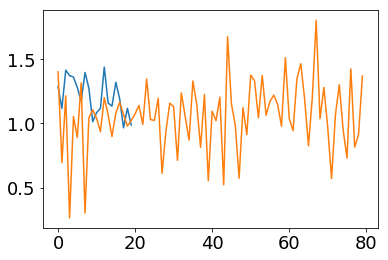

In [106]:
plt.plot(train_res_recon_error)
plt.plot(eval_res_recon_error)


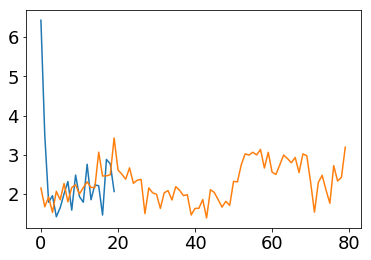

In [107]:
plt.plot(train_res_perplexity)
plt.plot(eval_res_perplexity)


In [120]:
checkpoint_dir

'/home/ubuntu/speech2speech/checkpoints/249_100'

In [122]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / std
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()
obj={"model_state_dict": model.state_dict(), 
                    "optimizer_state_dict": optimizer.state_dict()}
torch.save(obj, os.path.join(checkpoint_dir,'checkpoint_state_dict_15k_iter.pt'))

100 iterations
recon_error: 0.424
perplexity: 15.570

200 iterations
recon_error: 0.440
perplexity: 16.391

300 iterations
recon_error: 0.446
perplexity: 16.637

400 iterations
recon_error: 0.427
perplexity: 16.094

500 iterations
recon_error: 0.425
perplexity: 16.414

600 iterations
recon_error: 0.420
perplexity: 16.451

700 iterations
recon_error: 0.421
perplexity: 16.539

800 iterations
recon_error: 0.433
perplexity: 16.679

900 iterations
recon_error: 0.417
perplexity: 17.299

1000 iterations
recon_error: 0.405
perplexity: 16.812

1100 iterations
recon_error: 0.419
perplexity: 17.530

1200 iterations
recon_error: 0.405
perplexity: 17.785

1300 iterations
recon_error: 0.405
perplexity: 18.109

1400 iterations
recon_error: 0.406
perplexity: 17.490

1500 iterations
recon_error: 0.393
perplexity: 18.058

1600 iterations
recon_error: 0.402
perplexity: 18.912

1700 iterations
recon_error: 0.389
perplexity: 18.376

1800 iterations
recon_error: 0.383
perplexity: 18.073

1900 iterations
rec

15000 iterations
recon_error: 0.080
perplexity: 23.334



In [123]:
mean = 0.
meansq = 0.
for data in validation_loader:
    mean = data[0].mean()
    meansq = (data[0]**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor(0.2264)
std: tensor(1.6025)



In [124]:
model.eval()
eval_res_recon_error = []
eval_res_perplexity = []

for i in xrange(num_training_updates):

        (data, _) = next(iter(validation_loader))
        data = data.to(device)
            
            
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        vq_loss, data_recon, perplexity = model(batch_X)
            
        recon_error = F.mse_loss(data_recon, batch_X) / std
        loss = recon_error + vq_loss
            
        
        eval_res_recon_error.append(recon_error.item())
        eval_res_perplexity.append(perplexity.item())
        if (i+1) % 100 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

100 iterations
recon_error: 0.080
perplexity: 23.334

200 iterations
recon_error: 0.080
perplexity: 23.334

300 iterations
recon_error: 0.080
perplexity: 23.334

400 iterations
recon_error: 0.080
perplexity: 23.334

500 iterations
recon_error: 0.080
perplexity: 23.334

600 iterations
recon_error: 0.080
perplexity: 23.334

700 iterations
recon_error: 0.080
perplexity: 23.334

800 iterations
recon_error: 0.080
perplexity: 23.334

900 iterations
recon_error: 0.080
perplexity: 23.334

1000 iterations
recon_error: 0.080
perplexity: 23.334

1100 iterations
recon_error: 0.080
perplexity: 23.334

1200 iterations
recon_error: 0.080
perplexity: 23.334

1300 iterations
recon_error: 0.080
perplexity: 23.334

1400 iterations
recon_error: 0.080
perplexity: 23.334

1500 iterations
recon_error: 0.080
perplexity: 23.334

1600 iterations
recon_error: 0.080
perplexity: 23.334

1700 iterations
recon_error: 0.080
perplexity: 23.334

1800 iterations
recon_error: 0.080
perplexity: 23.334

1900 iterations
rec

15000 iterations
recon_error: 0.080
perplexity: 23.334



## Plot Loss 

In [113]:
len(train_res_recon_error)

15000

In [125]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)
eval_res_recon_error_smooth = savgol_filter(eval_res_recon_error, 201, 7)
eval_res_perplexity_smooth = savgol_filter(eval_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

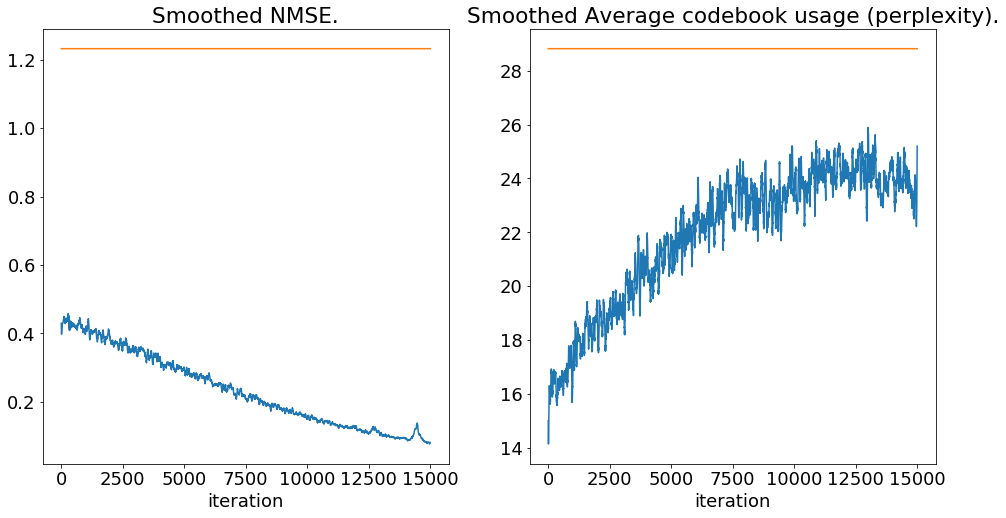

In [126]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.plot(eval_res_recon_error_smooth)
#ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.plot(eval_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## Reconstructions 

In [116]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize, speaker_dic, speaker_id)

In [117]:
(data, _) = next(iter(training_loader))
data = data.to(device)

vq_loss, data_recon, perplexity = model(data)

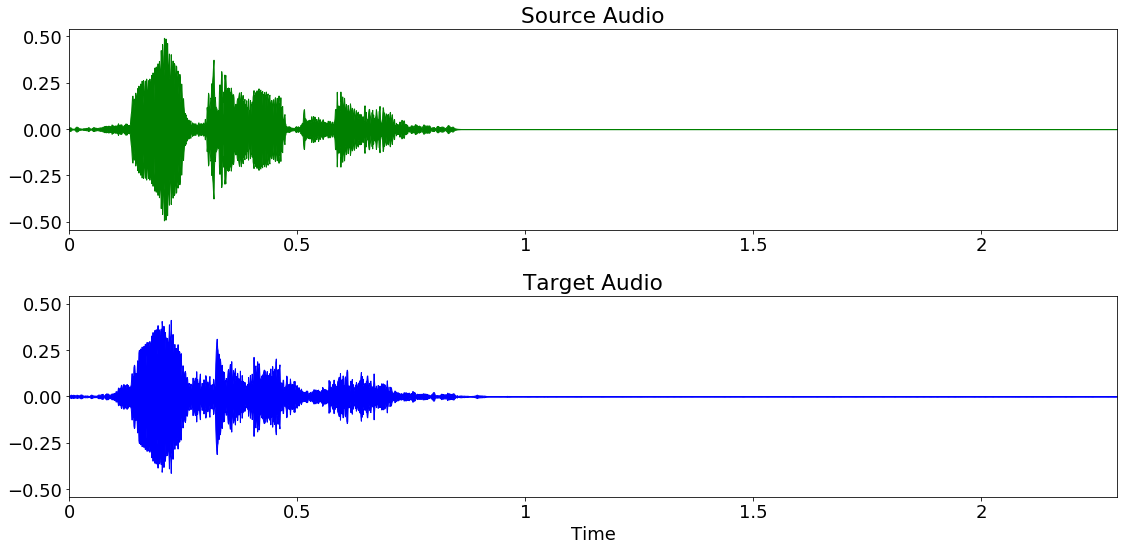

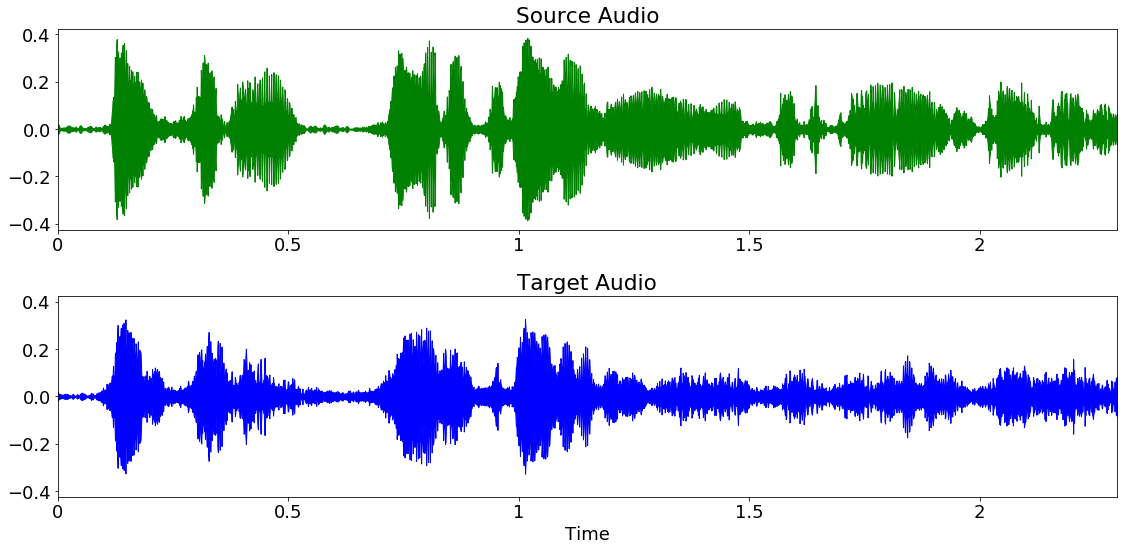

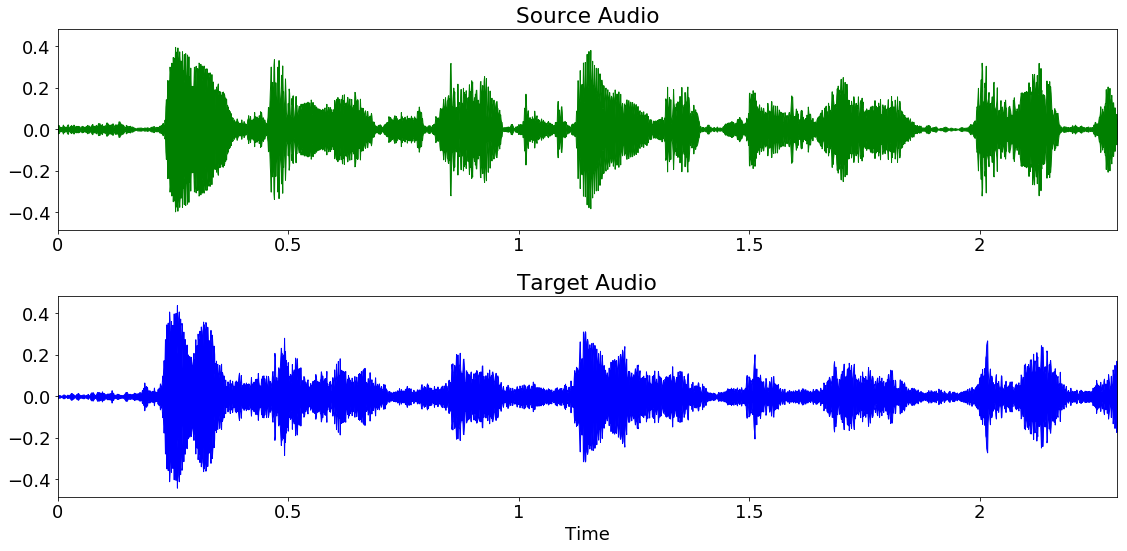

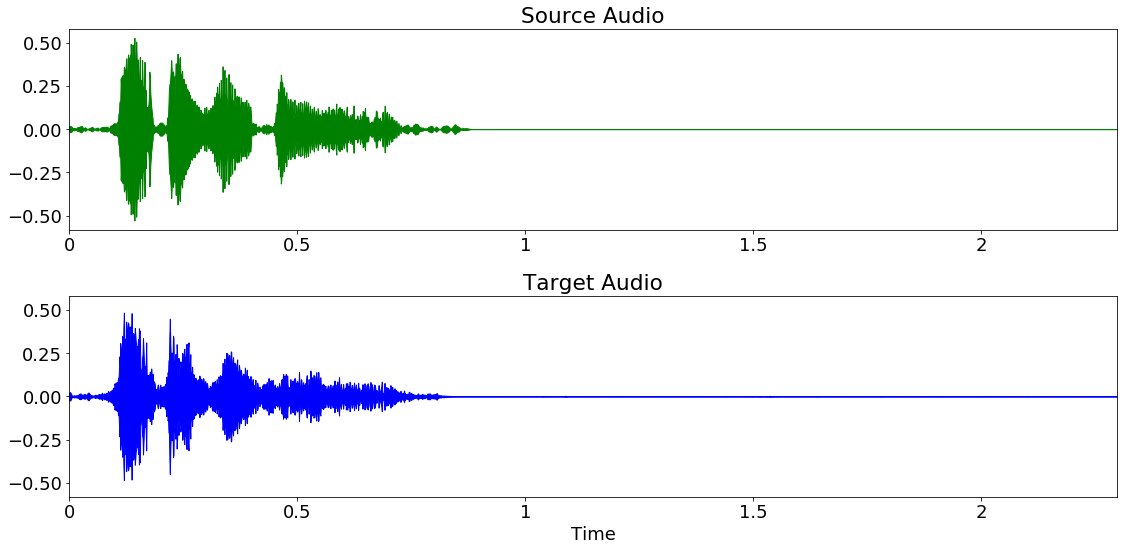

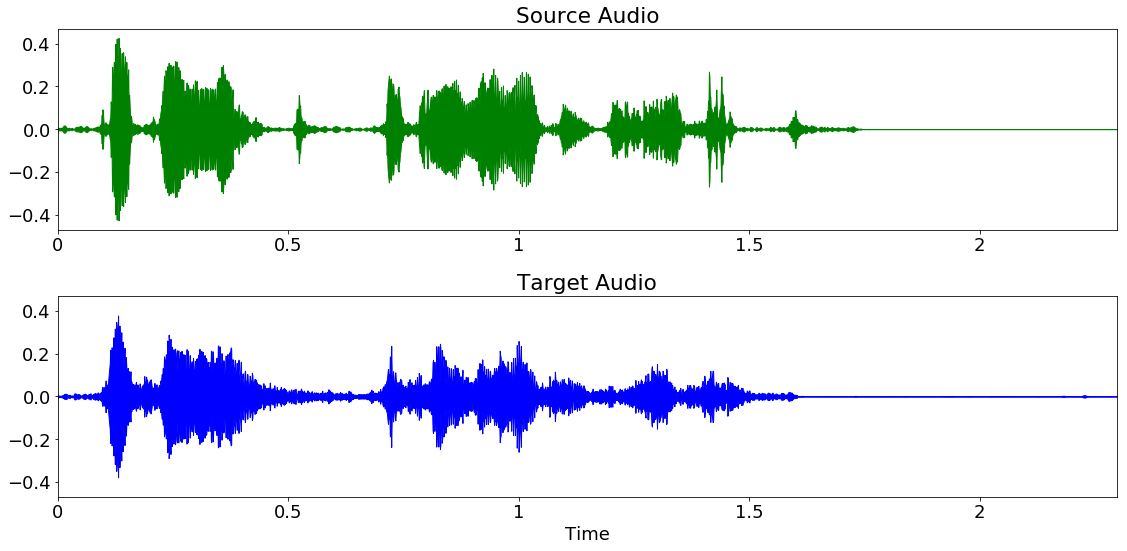

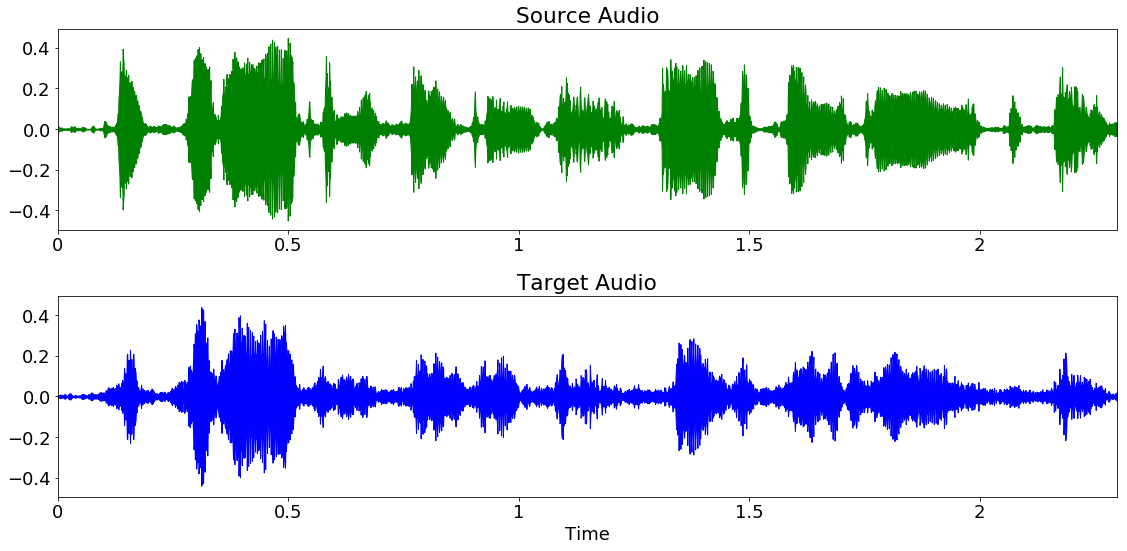

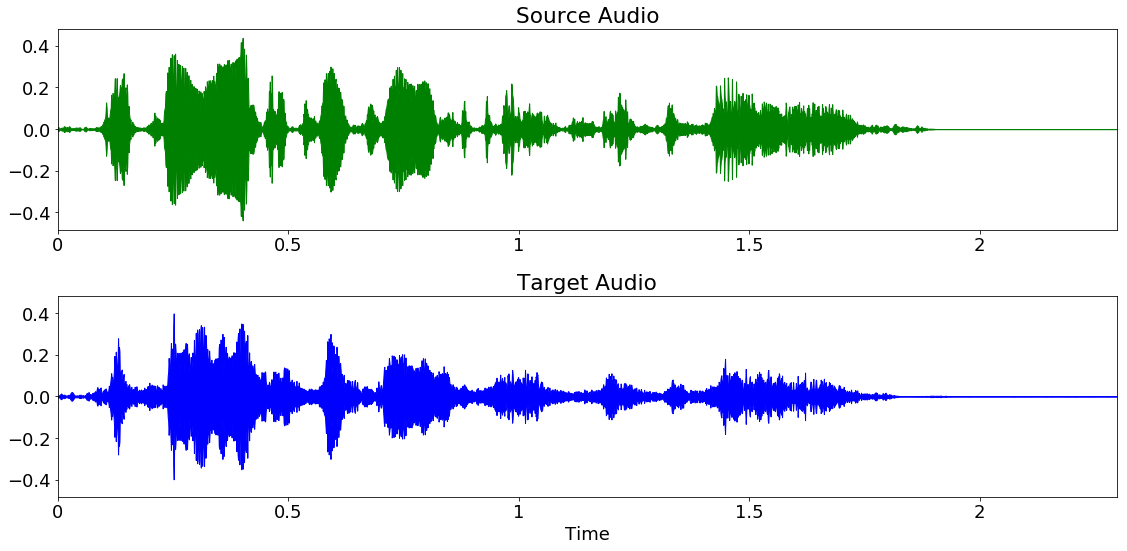

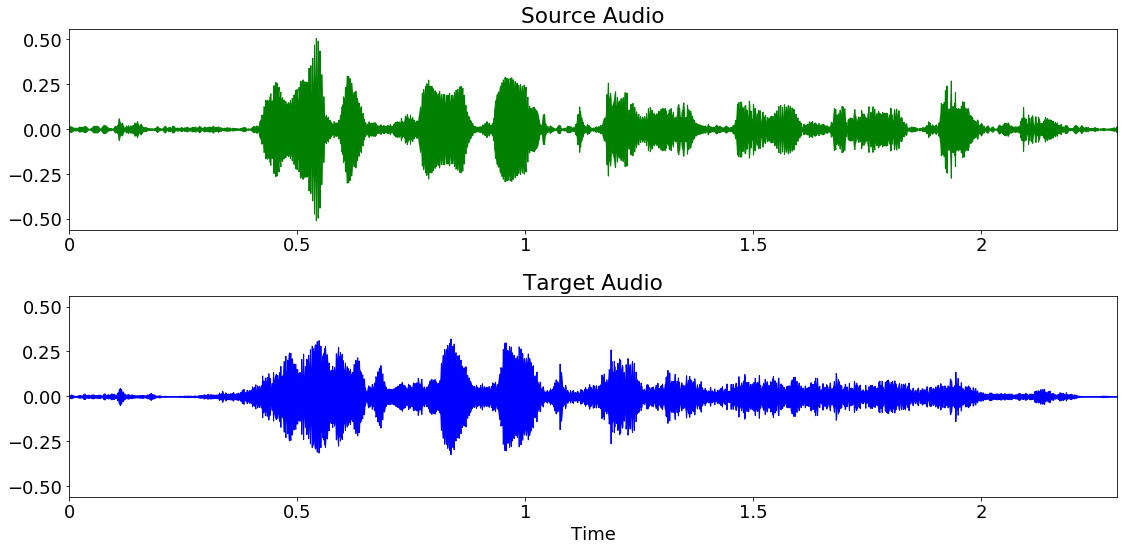

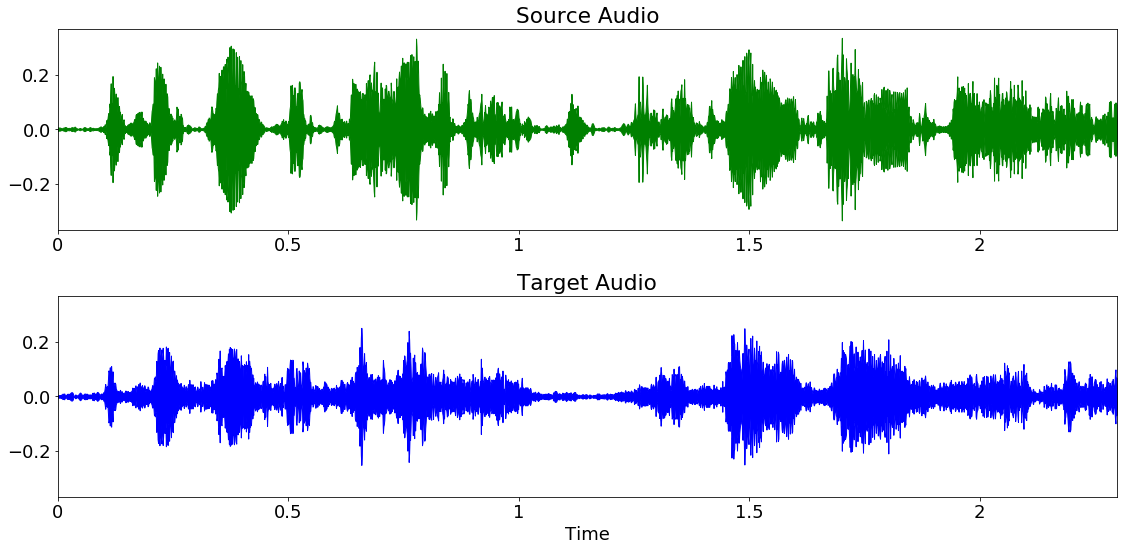

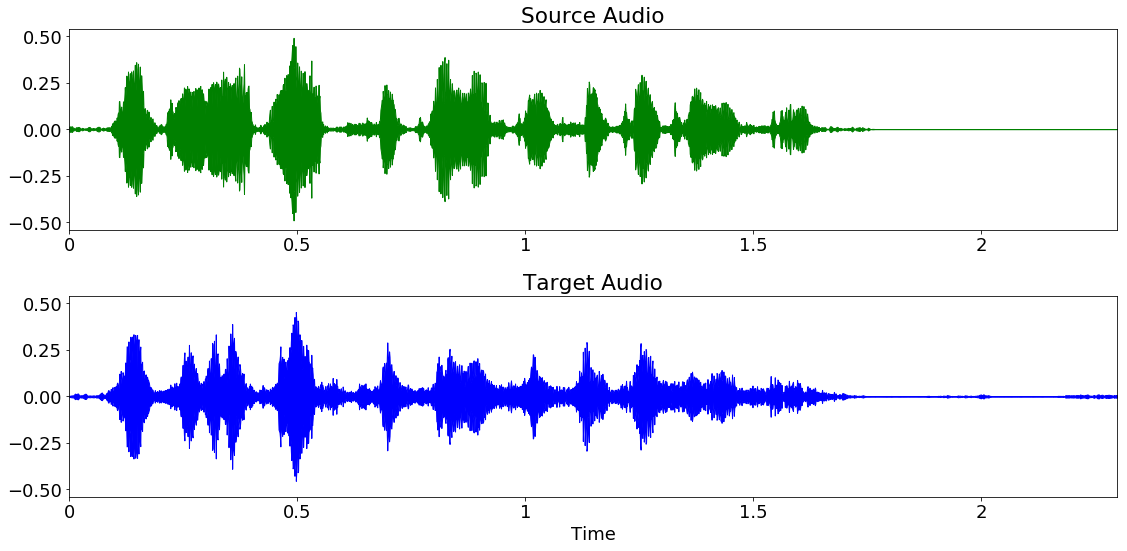

In [118]:
for i in range(len(data)):
    data_np = (data[i].to(torch.device("cpu"))).detach().numpy();
    data_griffin_lim = librosa.griffinlim(data_np)
    data_recon_np = (data_recon[i].to(torch.device("cpu"))).detach().numpy();
    data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = '/home/ubuntu/speech2speech/plots/plot_100_' + str(i) + '.png'
    source_aud_path = '/home/ubuntu/speech2speech/output/source_100_' + str(i) + '.wav'
    target_aud_path = '/home/ubuntu/speech2speech/output/target_100_' + str(i) + '.wav'
    
    librosa.display.waveplot(data_griffin_lim, color = 'g')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.waveplot(data_recon_griffin_lim, color = 'b')
    plt.tight_layout()
    fig.savefig(output_path)
    
    librosa.output.write_wav(source_aud_path,data_griffin_lim, 16000)
    librosa.output.write_wav(target_aud_path,data_recon_griffin_lim, 16000)

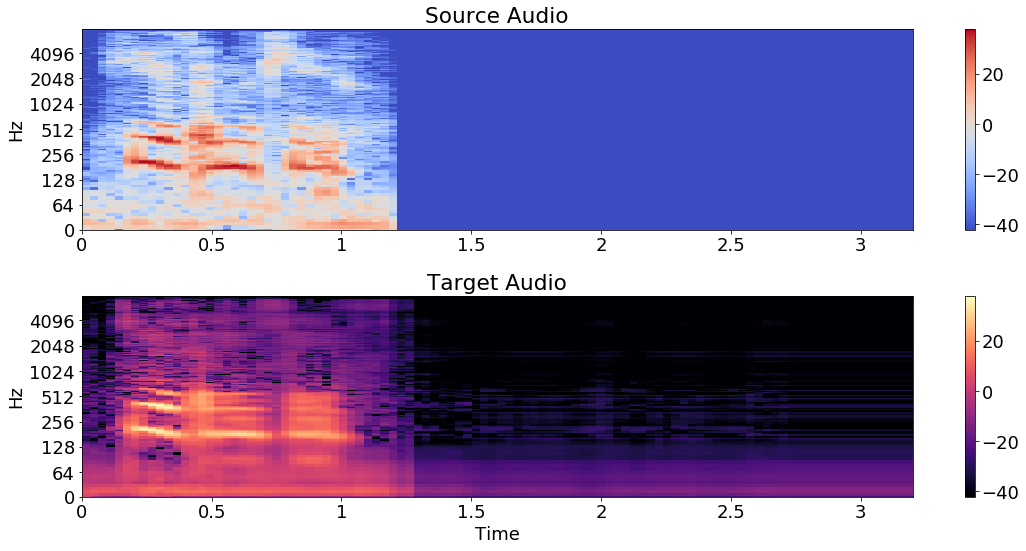

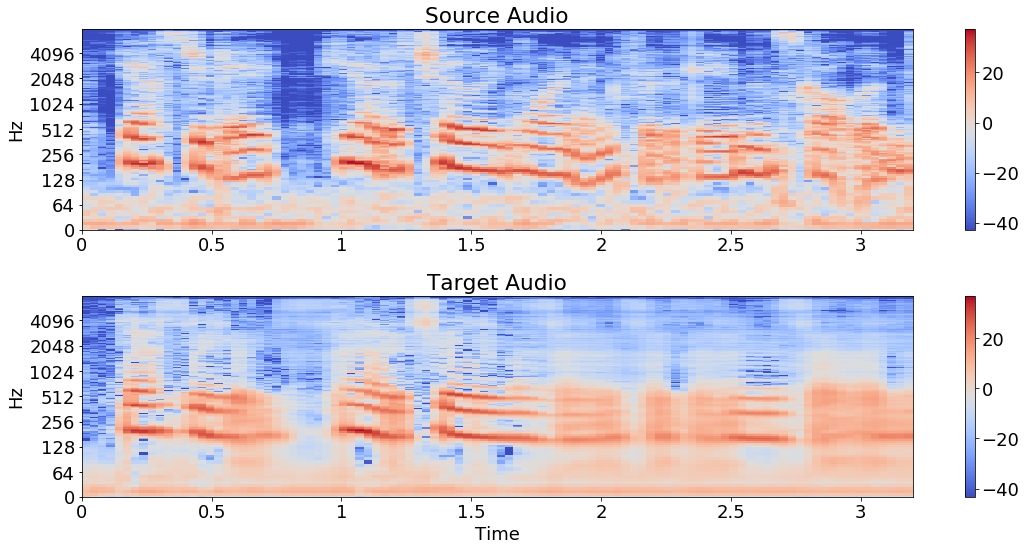

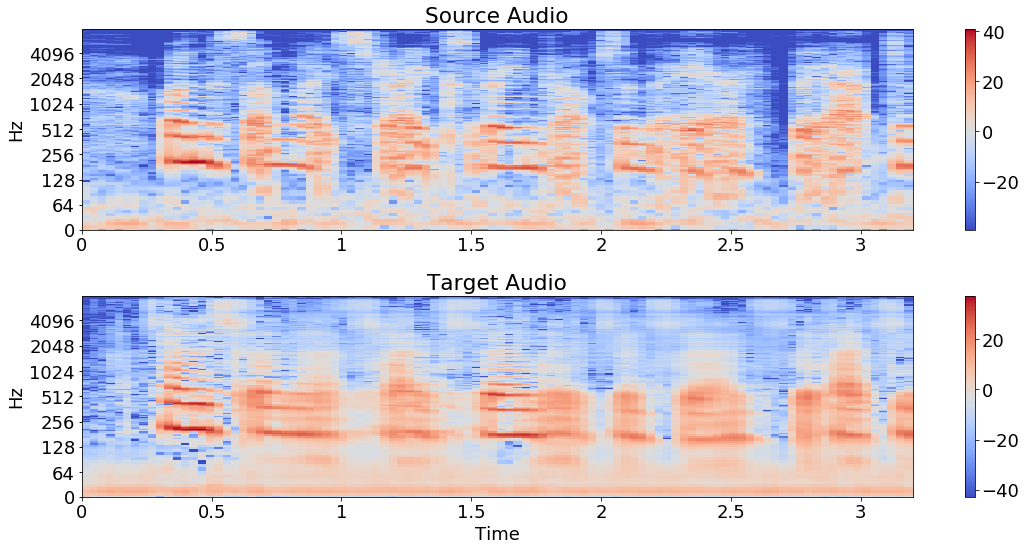

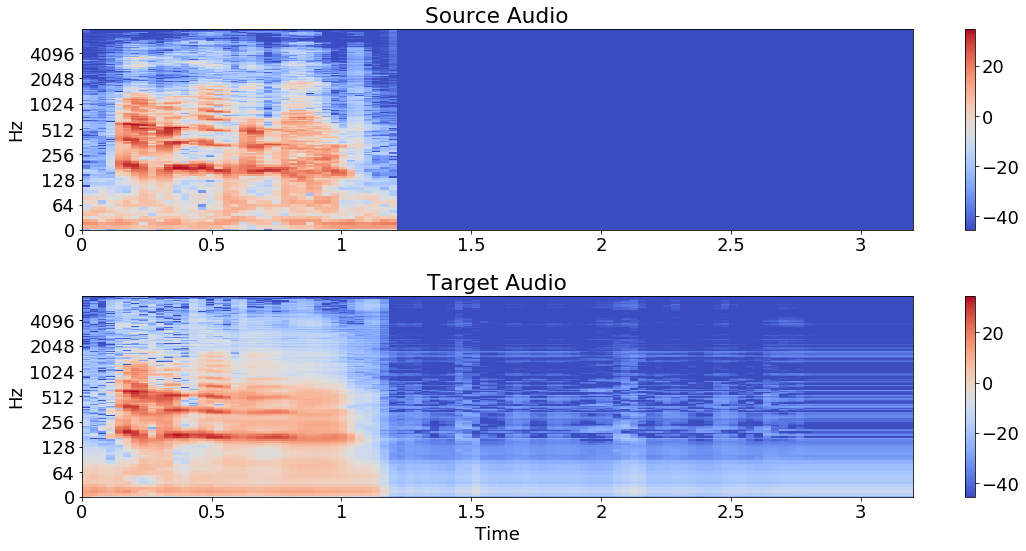

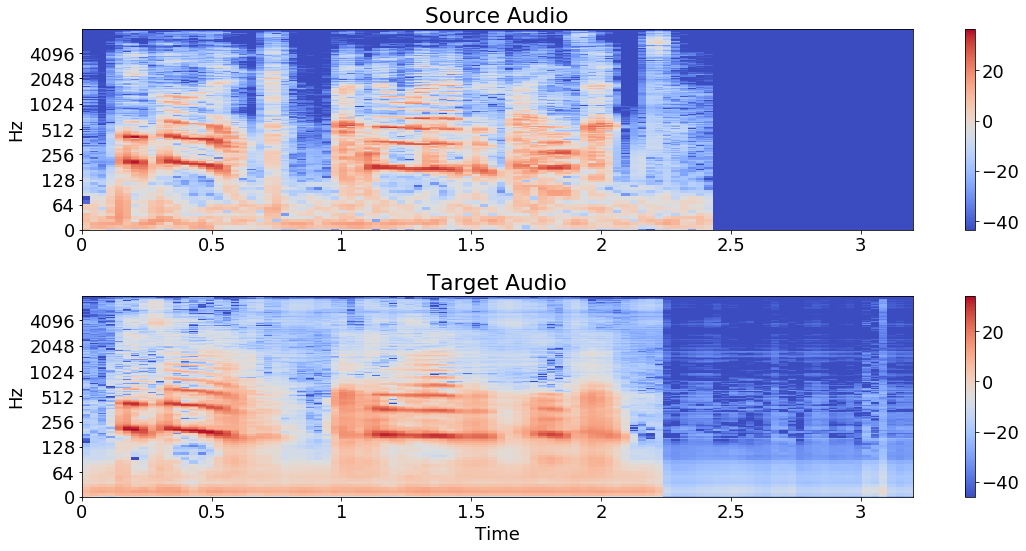

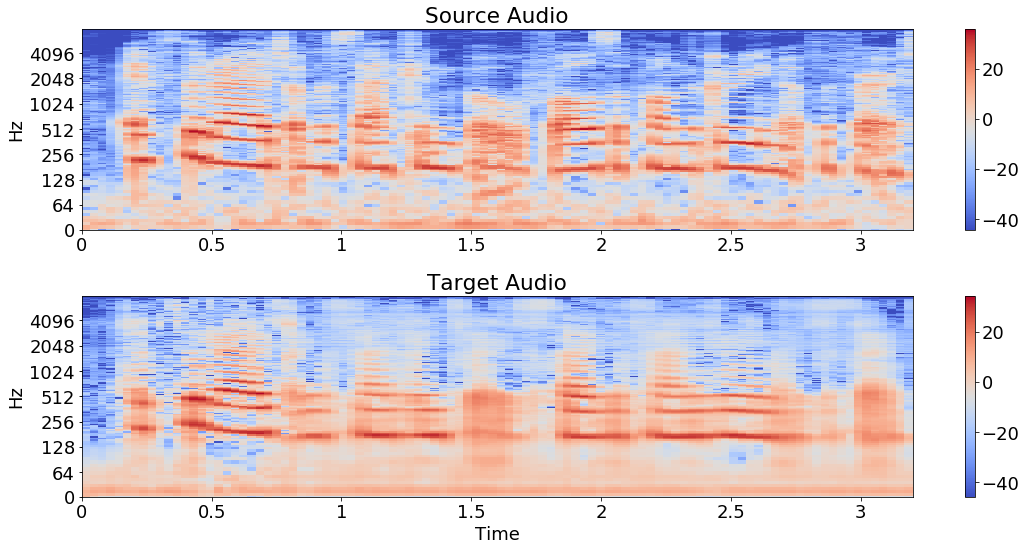

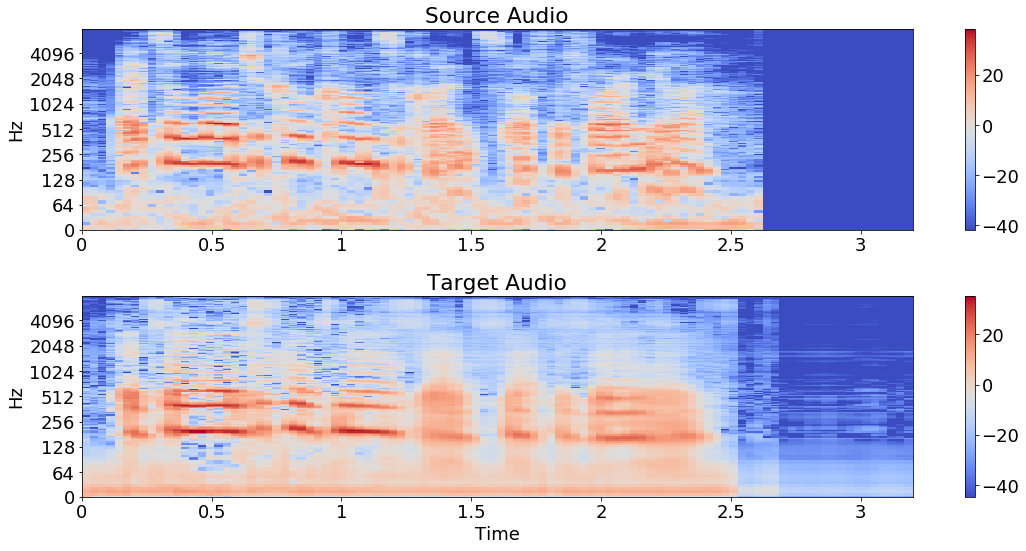

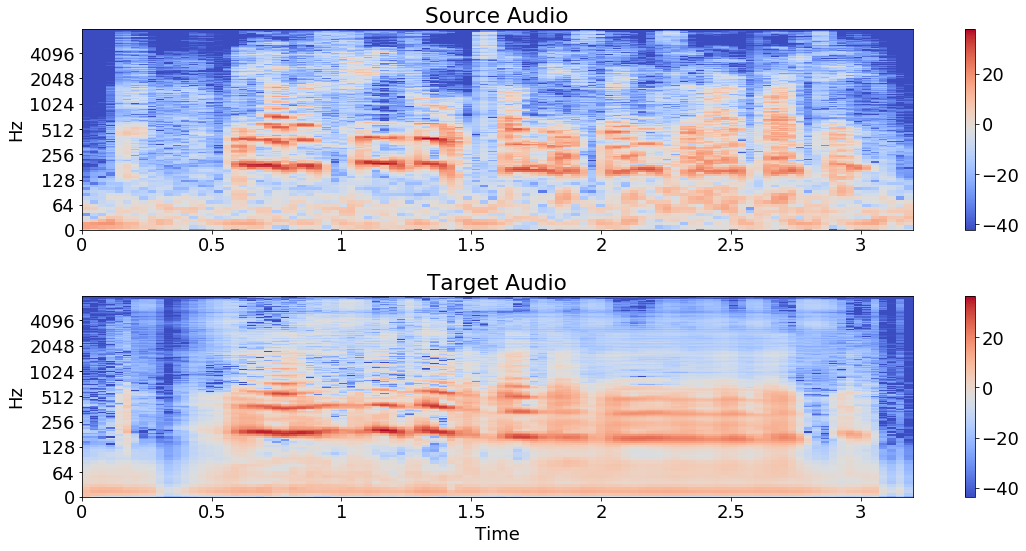

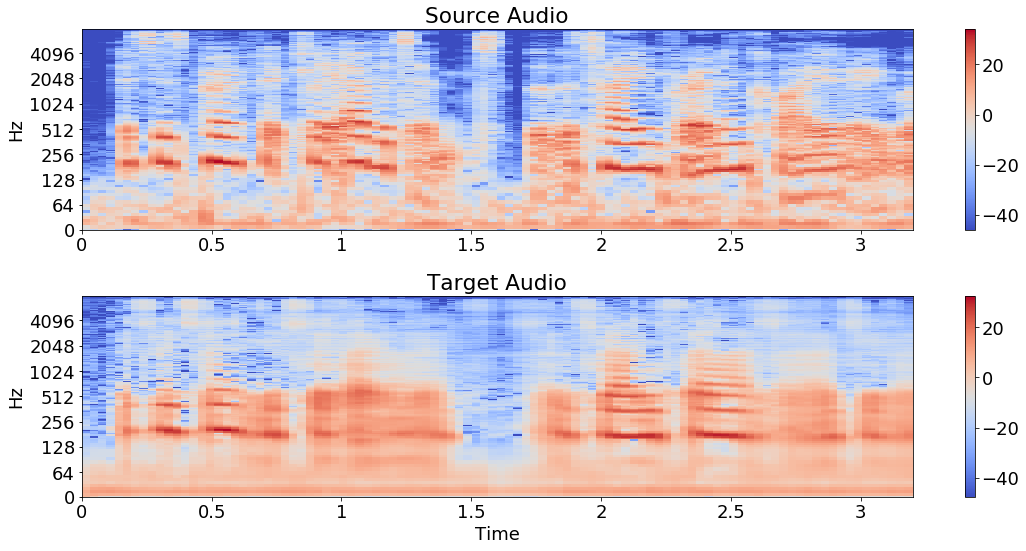

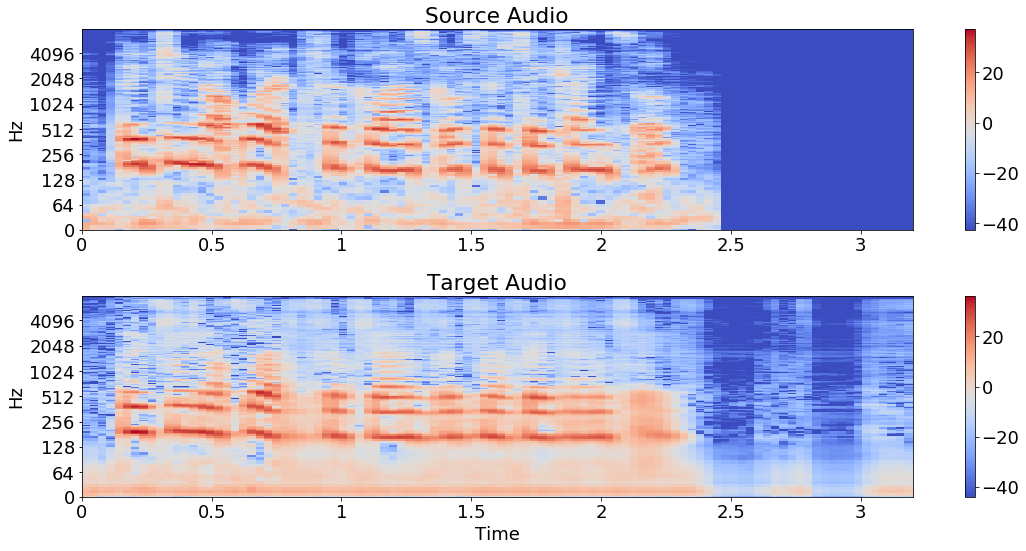

In [119]:
for i in range(len(data)):
    data_np = (data[i].to(torch.device("cpu"))).detach().numpy();
    data_np = librosa.amplitude_to_db(abs(data_np))
    data_recon_np = (data_recon[i].to(torch.device("cpu"))).detach().numpy();
    data_recon_np = librosa.amplitude_to_db(abs(data_recon_np))
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = '/home/ubuntu/speech2speech/plots/spec_plot_' + str(i) + '.png'

    librosa.display.specshow(data_np, sr=16000, x_axis='time', y_axis='log')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.colorbar()
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.specshow(data_recon_np, sr=16000, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.tight_layout()
    fig.savefig(output_path)